In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from srf.simulation import SimulationParams, generate_simulation_data
from srf.plotting import plot_simulation, plot_images_from_embedding, plot_tri_factors
from srf.models import SymmetricCD
from srf.models.trifactor_sym import TriFactorADMM
from srf.helpers import CVParams
from srf.datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tools.rsa import correlate_rsms

/LOCAL/fmahner/srf/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating membership matrix with 30 samples and 5 clusters


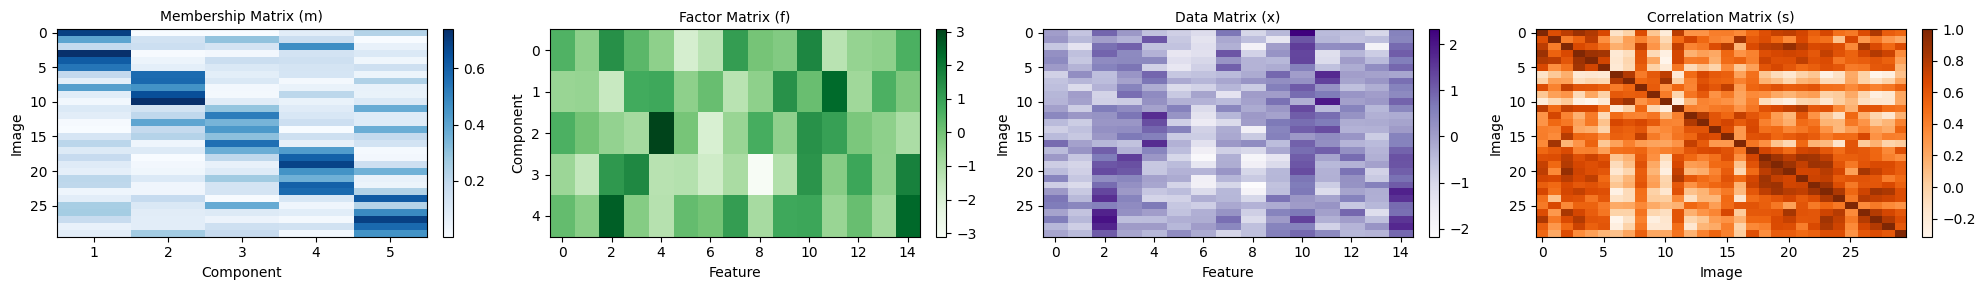

In [23]:
params = SimulationParams()
params.n = 30
params.p = 15
params.primary_concentration = 5.0
params.k = 5
params.snr = 0.7

x, m, f, s = generate_simulation_data(params)
fig = plot_simulation(x, m, f, s)

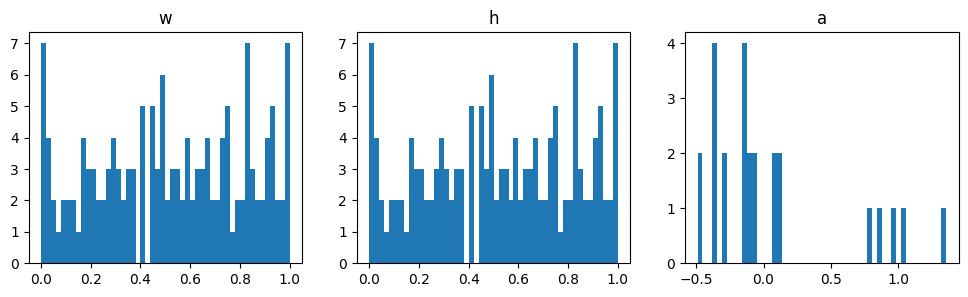

In [28]:
model = TrifactorCD(
    max_iter=300, rank=params.k, alpha=1.0, beta=1.0, verbose=True, tol=1e-8
)
model.fit(s)
plot_tri_factors(model)
plt.show()

### Cholesky Decomposition to check if w and h are similar to a

In [6]:
# we solve a^2 = wah
l = np.linalg.cholesky(model.a_)
wl = model.w_ @ l
hl = model.h_ @ l
wah = wl @ hl.T
print(np.linalg.norm(s - wah))

1.771704286059897


### Rank Selection (optimal dimensionality)

TODOs
 
- Show variance across folds
- Think about projection mapping and correct masking

Generating membership matrix with 300 samples and 10 clusters


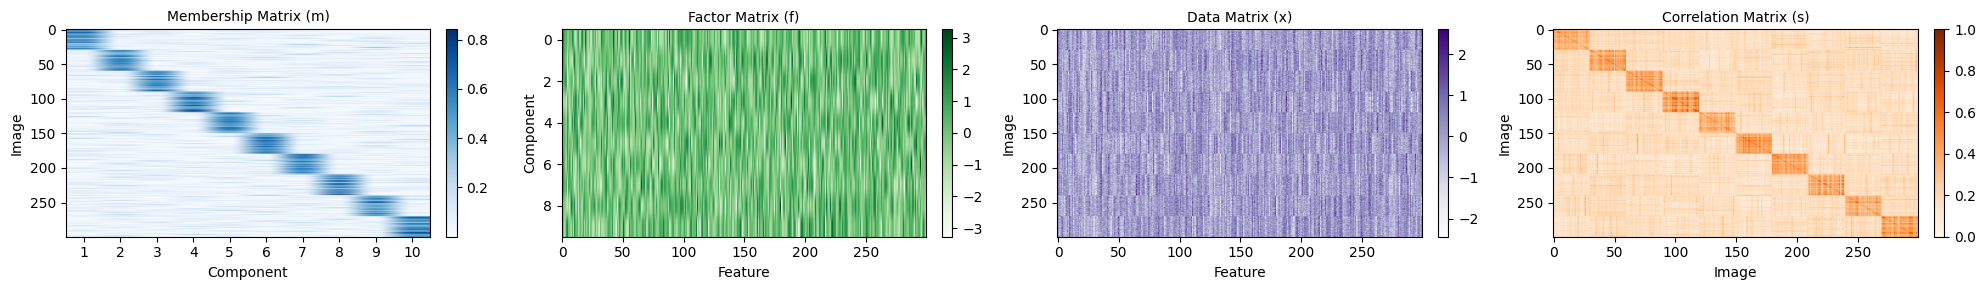

In [7]:
params.k = 10
params.n = 300
params.p = 300
params.primary_concentration = 10.0
params.bna = 0.00001
x, m, f, s = generate_simulation_data(params)
s = x @ x.T
s = s - s.min()
s = s / s.max()
fig = plot_simulation(x, m, f, s)

cluster_labels = np.argmax(m, axis=1)

In [8]:
from sklearn.model_selection import KFold

n = np.arange(s.shape[0])
kf = KFold(n_splits=5, random_state=0, shuffle=True)

# print the counter for each fold, eg how many samples are in each cluster for train and test respectively
for i, (train, test) in enumerate(kf.split(n)):
    print(f"Fold {i+1}:")
    for label in np.unique(cluster_labels):
        train_count = np.sum(cluster_labels[train] == label)
        test_count = np.sum(cluster_labels[test] == label)
        print(
            f"  Cluster {label}: Train count = {train_count}, Test count = {test_count}"
        )

Fold 1:
  Cluster 0: Train count = 23, Test count = 6
  Cluster 1: Train count = 24, Test count = 5
  Cluster 2: Train count = 24, Test count = 6
  Cluster 3: Train count = 25, Test count = 6
  Cluster 4: Train count = 25, Test count = 5
  Cluster 5: Train count = 25, Test count = 7
  Cluster 6: Train count = 24, Test count = 7
  Cluster 7: Train count = 19, Test count = 9
  Cluster 8: Train count = 28, Test count = 3
  Cluster 9: Train count = 23, Test count = 6
Fold 2:
  Cluster 0: Train count = 25, Test count = 4
  Cluster 1: Train count = 24, Test count = 5
  Cluster 2: Train count = 25, Test count = 5
  Cluster 3: Train count = 26, Test count = 5
  Cluster 4: Train count = 25, Test count = 5
  Cluster 5: Train count = 24, Test count = 8
  Cluster 6: Train count = 27, Test count = 4
  Cluster 7: Train count = 19, Test count = 9
  Cluster 8: Train count = 24, Test count = 7
  Cluster 9: Train count = 21, Test count = 8
Fold 3:
  Cluster 0: Train count = 19, Test count = 10
  Cluster

Generating membership matrix with 300 samples and 5 clusters
Running 350 tasks with 100 jobs


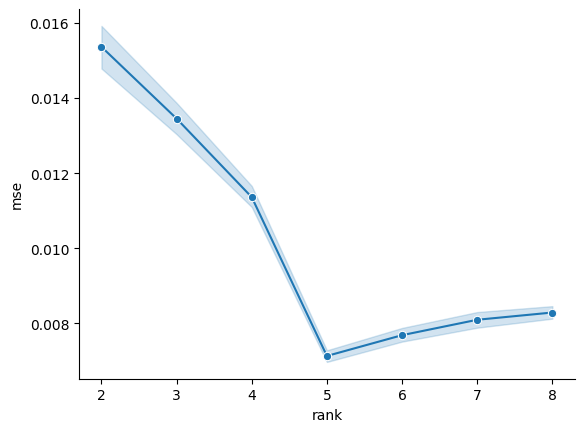

In [9]:
params.k = 5
x, m, f, s = generate_simulation_data(params)
s = x @ x.T
s = s - s.min()
s = s / s.max()

cv_params = CVParams()

cv_params.verbose = 0

cv_params.candidate_ranks = range(2, 9)
cv_params.n_repeats = 10
model = TrifactorCD(max_iter=300, rank=params.k, alpha=1.0, verbose=False, tol=1e-8)
# model = SymmetricCD(max_iter=1000, rank=params.k, alpha=1.0, verbose=False, tol=1e-8)
df = run_cv_rank_selection(
    model,
    s,
    cv_params.candidate_ranks,
    n_repeats=cv_params.n_repeats,
    n_splits=cv_params.n_splits,
    random_state=cv_params.random_state,
    verbose=cv_params.verbose,
)
sns.lineplot(df, x="rank", y="mse", marker="o")
sns.despine()
plt.show()

In [45]:
# --------------------------------------------------------------------- #
#      S  ≈  W diag(a) Hᵀ   +  α/2 · ‖W-H‖²      (W,H ≥ 0)             #
# --------------------------------------------------------------------- #
from dataclasses import dataclass, field
from typing import Dict, List, Optional
import numpy as np
from srf.models.nnls_block import nnlsm_blockpivot  # block pivot NNLS

EPS = 1e-12


def solve_a(S, W, H):
    G = (W.T @ W) * (H.T @ H) + EPS * np.eye(W.shape[1])
    rhs = np.diag(W.T @ S @ H)
    return np.linalg.solve(G, rhs)


def stack_nnls(B, A, init):
    AtA = A.T @ A
    AtB = A.T @ B
    X_T, *_ = nnlsm_blockpivot(AtA, AtB, is_input_prod=True, init=init.T)
    return X_T.T


def balance_cols(W, H, a):
    nW = np.sqrt((W**2).sum(0)) + EPS
    nH = np.sqrt((H**2).sum(0)) + EPS
    g = np.sqrt(nW * nH)
    W /= nW / g
    H /= nH / g
    a *= (nW / g) * (nH / g)
    return W, H, a


@dataclass
class DiagCoreCoupledNMF:
    rank: int
    alpha: Optional[float] = None  # if None we set it automatically
    max_iter: int = 300
    tol: float = 1e-6
    random_state: Optional[int] = None
    verbose: bool = False

    W_: np.ndarray = field(init=False, default=None)
    H_: np.ndarray = field(init=False, default=None)
    a_: np.ndarray = field(init=False, default=None)
    hist_: Dict[str, List[float]] = field(init=False, default_factory=dict)

    # --------------------------------------------------------------------- #
    def fit(self, S: np.ndarray):
        n = S.shape[0]
        rng = np.random.default_rng(self.random_state)
        W = rng.random((n, self.rank))
        H = W.copy()
        a = np.ones(self.rank)
        W, H, a = balance_cols(W, H, a)

        α = self.alpha
        if α is None:  # deterministic scale choice
            α = 0.5 * np.linalg.norm(S, "fro") / n

        obj_hist = []
        for it in range(1, self.max_iter + 1):
            # 1) diagonal ---------------------------------------------------
            a = solve_a(S, W, H)

            # 2) NNLS for W -------------------------------------------------
            A_W = np.vstack([H @ np.diag(a), np.sqrt(α) * np.eye(self.rank)])
            B_W = np.vstack([S.T, np.sqrt(α) * H.T])
            W = stack_nnls(B_W, A_W, W)

            # 3) NNLS for H -------------------------------------------------
            # --- NNLS for H -------------------------------------------------
            A_H = np.vstack(
                [W @ np.diag(a), np.sqrt(α) * np.eye(self.rank)]
            )  # (n+r) × r
            B_H = np.vstack([S, np.sqrt(α) * W.T])  # (n+r) × n
            H = stack_nnls(B_H, A_H, H)

            # 4) scale transfer --------------------------------------------
            W, H, a = balance_cols(W, H, a)

            # 5) objective --------------------------------------------------
            E = S - W @ np.diag(a) @ H.T
            f = 0.5 * (
                np.dot(E.ravel(), E.ravel())
                + α * np.dot((W - H).ravel(), (W - H).ravel())
            )
            obj_hist.append(f)

            if self.verbose and it % 20 == 0:
                print(f"iter {it:4d}  obj={f:.5e}")

            if it > 2 and abs(obj_hist[-2] - obj_hist[-1]) / obj_hist[-2] < self.tol:
                break

        self.w_, self.h_, self.a_ = W, H, a
        self.s_hat_ = self.w_ @ np.diag(self.a_) @ self.h_.T
        self.hist_ = {"obj": obj_hist}
        if self.verbose:
            print(f"converged in {it} iterations,  obj={f:.4e}")
        return self

    # helper
    def reconstruction(self):
        return self.W_ @ np.diag(self.a_) @ self.H_.T

In [21]:
# NOTE explained variance super bad, not correct at the moment.

data = load_dataset("peterson-animals")
rsm = data.rsm

# data = load_dataset("mur92")
# rsm = data.group_rsm
images = data.images

model = TriFactorADMM(
    rank=6,
    max_outer=1000,
    lam=1e-2,
    beta=100,
    verbose=True,
)
model.fit(rsm)
w = model.W_
# fig = plot_tri_factors(model)
plt.show()
corrs = correlate_rsms(rsm, model.s_hat_)
print("Correlation between original and reconstructed RSM:", corrs)

/LOCAL/fmahner/srf/srf/models/trifactor_sym.py:182: RuntimeWarning: overflow encountered in square
  obj_plain = (


it  999 obj_plain=69.0192
Correlation between original and reconstructed RSM: 0.9259989823458182


array([[ 2.17909716, -0.26984902, -0.59418151, -0.1721579 , -0.34089108,
        -0.05703524],
       [-0.27034147,  1.63152754, -0.26230681, -0.18745926, -0.21819914,
        -0.46656218],
       [-0.59433967, -0.26251152,  2.11152159, -0.18457399, -0.1831781 ,
        -0.12981273],
       [-0.17212812, -0.18809003, -0.18480769,  2.35832516, -0.34874169,
        -0.51159973],
       [-0.34066449, -0.21830791, -0.18326676, -0.34923637,  1.75068341,
        -0.29115811],
       [-0.05664777, -0.46624599, -0.1298362 , -0.51208156, -0.29155378,
         1.9592315 ]])

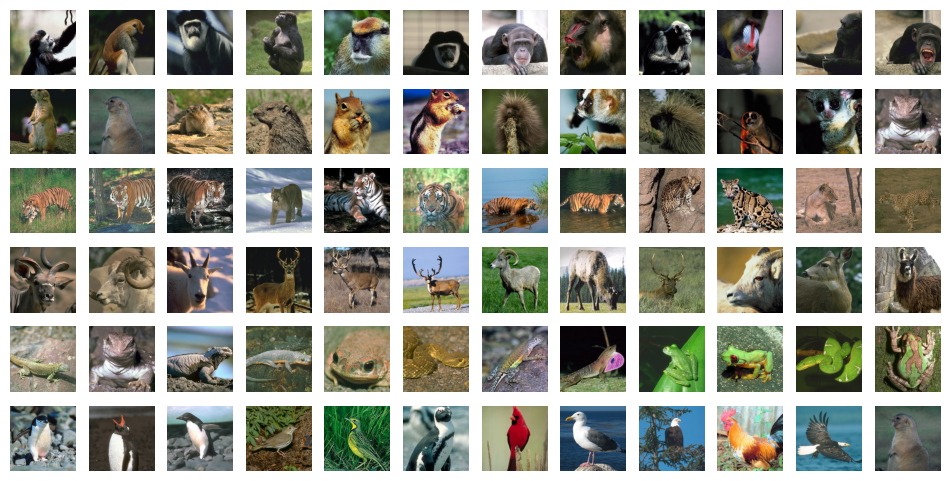

In [22]:
fig = plot_images_from_embedding(w, images, dpi=100)
plt.show()

Running 550 tasks with 100 jobs


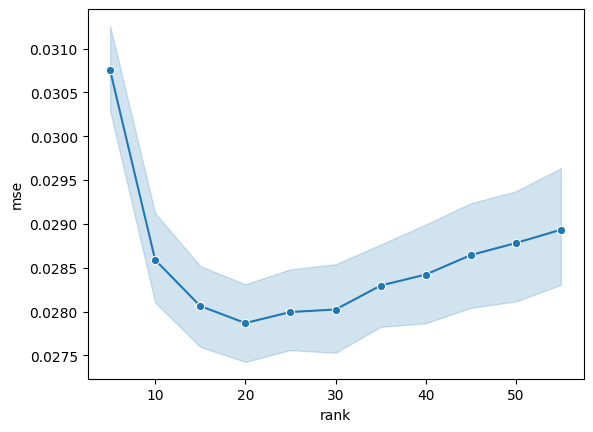

In [21]:
# run the rank selection
cv_params.candidate_ranks = range(5, 60, 5)
cv_params.n_repeats = 10
model = TrifactorCD(max_iter=300, rank=params.k, alpha=1.0, verbose=False, tol=1e-8)
df = run_cv_rank_selection(
    model,
    rsm,
    cv_params.candidate_ranks,
    n_repeats=cv_params.n_repeats,
    n_splits=cv_params.n_splits,
    random_state=cv_params.random_state,
    verbose=cv_params.verbose,
)
sns.lineplot(df, x="rank", y="mse", marker="o")
plt.show()

In [ ]:
#!/usr/bin/env python
# tri_factor_hrhc.py
#
#  Tri‑factor NMF with half‑row/half‑column cross‑validation
#  ---------------------------------------------------------
#  Author : <you>
#  Date   : 2025‑04‑17
#
#  Reproduces the experiment described in the ChatGPT answer:
#  – generates a Dirichlet–mixture data matrix
#  – converts it to a similarity matrix (Pearson correlation)
#  – factorises with the objective  ‖S − WAHᵀ‖² + α‖W − H‖²
#  – selects (rank k, regularisation α) by HR‑HC CV + tiny df‑penalty
#  – reports how often the selected rank equals the ground truth

import math
import numpy as np
from dataclasses import dataclass
from numpy.random import Generator, default_rng
from scipy.optimize import nnls


# ---------------------------------------------------------------------
# 1.  Simulation helpers
# ---------------------------------------------------------------------
@dataclass
class SimulationParams:
    n: int = 100  # samples / objects
    p: int = 50  # features  (for each object)
    k: int = 5  # TRUE latent rank
    snr: float = 1.0  # 1.0 = noiseless; 0.0 = pure noise
    rng_state: int = 0  # changes every trial

    primary_concentration: float = 10.0  # Dirichlet α for main cluster
    base_concentration: float = 1.0  # Dirichlet α for off‑clusters


def _dirichlet_memberships(n, k, prim_c, base_c, rng: Generator) -> np.ndarray:
    """Soft row‑memberships: one big component + small cross‑loadings."""
    m_hard = np.zeros((n, k))
    sizes = [n // k] * k
    for i in range(n - sum(sizes)):
        sizes[i] += 1
    start, prim_of = 0, np.zeros(n, dtype=int)
    for c, sz in enumerate(sizes):
        m_hard[start : start + sz, c] = 1.0
        prim_of[start : start + sz] = c
        start += sz
    m_soft = np.zeros_like(m_hard, dtype=float)
    for i in range(n):
        α = np.ones(k) * base_c
        α[prim_of[i]] = prim_c
        m_soft[i] = rng.dirichlet(α)
    return m_soft


def _feature_matrix(p, k, rng: Generator) -> np.ndarray:
    return rng.normal(size=(k, p))


def _add_noise(x, snr, rng: Generator) -> np.ndarray:
    snr = float(np.clip(snr, 1e-12, 1.0))
    sig_std = np.std(x, ddof=1)
    noise = rng.standard_normal(size=x.shape) * sig_std
    return math.sqrt(snr) * x + math.sqrt(1.0 - snr) * noise


def simulate_similarity(params: SimulationParams) -> np.ndarray:
    rng = default_rng(params.rng_state)
    M = _dirichlet_memberships(
        params.n,
        params.k,
        params.primary_concentration,
        params.base_concentration,
        rng,
    )
    F = _feature_matrix(params.p, params.k, rng)
    X = _add_noise(M @ F, params.snr, rng)
    return np.corrcoef(X)  # S ∈ ℝⁿˣⁿ, symmetric, non‑negative


# ---------------------------------------------------------------------
# 2.  Tri‑factor NMF (exactly your update rules, row‑wise NNLS)
# ---------------------------------------------------------------------
def _update_A(S, W, H, eps=1e-12):
    WT_W = W.T @ W + eps * np.eye(W.shape[1])
    HT_H = H.T @ H + eps * np.eye(H.shape[1])
    return np.linalg.solve(WT_W, W.T @ S @ H) @ np.linalg.inv(HT_H)


def _update_W(S, W, H, A, alpha):
    n, k = W.shape
    sa = math.sqrt(alpha)
    design = np.vstack(((A @ H.T).T, sa * np.eye(k)))  # (n+k) × k
    for i in range(n):
        rhs = np.concatenate((S[i], sa * H[i]))
        W[i] = nnls(design, rhs)[0]
    return W


def _update_H(S, W, H, A, alpha):
    n, k = H.shape
    sa = math.sqrt(alpha)
    design = np.vstack(((A.T @ W.T).T, sa * np.eye(k)))
    for j in range(n):
        rhs = np.concatenate((S[:, j], sa * W[j]))
        H[j] = nnls(design, rhs)[0]
    return H


def trifactor(S, k, alpha, iters=30, seed=None):
    rng = default_rng(seed)
    n = S.shape[0]
    W = rng.random((n, k)) + 0.1
    H = rng.random((n, k)) + 0.1
    A = np.eye(k)
    for _ in range(iters):
        A = _update_A(S, W, H)
        W = _update_W(S, W, H, A, alpha)
        H = _update_H(S, W, H, A, alpha)
    return W, H, A


# ---------------------------------------------------------------------
# 3.  Half‑row / half‑column cross‑validation
# ---------------------------------------------------------------------
def _infer_latent_halfrow(
    s_row_fit, W_fit, H_fit, A, alpha, iters=6
) -> tuple[np.ndarray, np.ndarray]:
    k = W_fit.shape[1]
    sa = math.sqrt(alpha)
    design_row = np.vstack(((A @ H_fit.T).T, sa * np.eye(k)))
    design_col = np.vstack(((A.T @ W_fit.T).T, sa * np.eye(k)))
    w = W_fit.mean(0).clip(min=1e-6)
    h = H_fit.mean(0).clip(min=1e-6)
    for _ in range(iters):
        w = nnls(design_row, np.concatenate((s_row_fit, sa * h)))[0]
        h = nnls(design_col, np.concatenate((s_row_fit, sa * w)))[0]
    return w, h


def hrhc_cv_mse(
    S,
    k,
    alpha,
    *,
    test_prop=0.2,
    fit_prop=0.5,
    reps=1,
    seed=None,
) -> float:
    """Half‑row half‑column cross‑validated MSE."""
    rng = default_rng(seed)
    n = S.shape[0]
    total_err = 0.0
    total_num = 0

    for _ in range(reps):
        perm = rng.permutation(n)
        n_test = max(1, int(n * test_prop))
        Ω = perm[:n_test]  # test objectsimport math


import numpy as np
from dataclasses import dataclass
from numpy.random import default_rng
from scipy.optimize import nnls


# ---------------------------------------------------------------------
# 1.  Simulation helpers
# ---------------------------------------------------------------------
@dataclass
class SimulationParams:
    n: int = 100  # samples / objects
    p: int = 50  # features  (for each object)
    k: int = 5  # TRUE latent rank
    snr: float = 1.0  # 1.0 = noiseless; 0.0 = pure noise
    rng_state: int = 0  # changes every trial

    primary_concentration: float = 10.0  # Dirichlet α for main cluster
    base_concentration: float = 1.0  # Dirichlet α for off‑clusters


def _dirichlet_memberships(n, k, prim_c, base_c, rng):
    m_hard = np.zeros((n, k))
    sizes = [n // k] * k
    for i in range(n - sum(sizes)):
        sizes[i] += 1
    start = 0
    prim_of = np.zeros(n, dtype=int)
    for c, sz in enumerate(sizes):
        m_hard[start : start + sz, c] = 1.0
        prim_of[start : start + sz] = c
        start += sz
    m_soft = np.zeros_like(m_hard, dtype=float)
    for i in range(n):
        alpha = np.ones(k) * base_c
        alpha[prim_of[i]] = prim_c
        m_soft[i] = rng.dirichlet(alpha)
    return m_soft


def _feature_matrix(p, k, rng):
    return rng.normal(size=(k, p))


def _add_noise(x, snr, rng):
    snr = float(np.clip(snr, 1e-12, 1.0))
    sig_std = np.std(x, ddof=1)
    noise = rng.standard_normal(size=x.shape) * sig_std
    return math.sqrt(snr) * x + math.sqrt(1.0 - snr) * noise


def simulate_similarity(params: SimulationParams):
    rng = default_rng(params.rng_state)
    M = _dirichlet_memberships(
        params.n,
        params.k,
        params.primary_concentration,
        params.base_concentration,
        rng,
    )
    F = _feature_matrix(params.p, params.k, rng)
    X = _add_noise(M @ F, params.snr, rng)
    return np.corrcoef(X)


# ---------------------------------------------------------------------
# 2.  Tri‑factor NMF (exactly your update rules, row‑wise NNLS)
# ---------------------------------------------------------------------
def _update_A(S, W, H, eps=1e-12):
    WT_W = W.T @ W + eps * np.eye(W.shape[1])
    HT_H = H.T @ H + eps * np.eye(H.shape[1])
    return np.linalg.solve(WT_W, W.T @ S @ H) @ np.linalg.inv(HT_H)


def _update_W(S, W, H, A, alpha):
    n, k = W.shape
    sqrt_alpha = math.sqrt(alpha)
    design = np.vstack(((A @ H.T).T, sqrt_alpha * np.eye(k)))
    for i in range(n):
        rhs = np.concatenate((S[i], sqrt_alpha * H[i]))
        W[i] = nnls(design, rhs)[0]
    return W


def _update_H(S, W, H, A, alpha):
    n, k = H.shape
    sqrt_alpha = math.sqrt(alpha)
    design = np.vstack(((A.T @ W.T).T, sqrt_alpha * np.eye(k)))
    for j in range(n):
        rhs = np.concatenate((S[:, j], sqrt_alpha * W[j]))
        H[j] = nnls(design, rhs)[0]
    return H


def normalize_factors_(w, h, a, eps: float = 1e-12):
    k = w.shape[1]
    # rescale rows of A  (⇔ columns of W)
    for r in range(k):
        s = max(w[:, r].max(), eps)
        w[:, r] /= s
        a[r, :] *= s

    # rescale columns of A  (⇔ columns of H)
    for r in range(k):
        s = max(h[:, r].max(), eps)
        h[:, r] /= s
        a[:, r] *= s


def trifactor(S, k, alpha, iters=300, seed=None):
    rng = default_rng(seed)
    n = S.shape[0]
    W = rng.random((n, k)) + 0.1
    H = rng.random((n, k)) + 0.1
    A = np.eye(k)
    for _ in range(iters):
        A = _update_A(S, W, H)
        W = _update_W(S, W, H, A, alpha)
        H = _update_H(S, W, H, A, alpha)
        # TODO Maybe normalize factors please
        normalize_factors_(W, H, A)
    return W, H, A


# ---------------------------------------------------------------------
# 3.  Half‑row / half‑column cross‑validation
# ---------------------------------------------------------------------
def _infer_latent_halfrow(s_row_fit, W_fit, H_fit, A, alpha, iters=6):
    k = W_fit.shape[1]
    sqrt_alpha = math.sqrt(alpha)
    design_row = np.vstack(((A @ H_fit.T).T, sqrt_alpha * np.eye(k)))
    design_col = np.vstack(((A.T @ W_fit.T).T, sqrt_alpha * np.eye(k)))
    w = W_fit.mean(0).clip(min=1e-6)
    h = H_fit.mean(0).clip(min=1e-6)
    for _ in range(iters):
        w = nnls(design_row, np.concatenate((s_row_fit, sqrt_alpha * h)))[0]
        h = nnls(design_col, np.concatenate((s_row_fit, sqrt_alpha * w)))[0]
    return w, h


def hrhc_cv_mse(
    S,
    k,
    alpha,
    *,
    test_prop=0.2,
    fit_prop=0.5,
    reps=1,
    seed=None,
):
    rng = default_rng(seed)
    n = S.shape[0]
    total_err = 0.0
    total_num = 0

    for _ in range(reps):
        perm = rng.permutation(n)
        n_test = max(1, int(n * test_prop))
        test_indices = perm[:n_test]
        train_indices = perm[n_test:]
        pos = {idx: i for i, idx in enumerate(train_indices)}

        W_tr, H_tr, A = trifactor(
            S[np.ix_(train_indices, train_indices)], k, alpha, seed=rng.integers(1e6)
        )

        W_te = np.zeros((n_test, k))
        H_te = np.zeros((n_test, k))

        for t, obj in enumerate(test_indices):
            fit_size = max(1, int(len(train_indices) * fit_prop))
            J_fit = rng.choice(train_indices, size=fit_size, replace=False)
            J_score = np.setdiff1d(train_indices, J_fit, assume_unique=True)

            idx_fit = [pos[j] for j in J_fit]
            idx_score = [pos[j] for j in J_score]

            w, h = _infer_latent_halfrow(
                S[obj, J_fit], W_tr[idx_fit], H_tr[idx_fit], A, alpha
            )
            W_te[t], H_te[t] = w, h

            if idx_score:
                row_true = S[obj, J_score]
                row_pred = w @ A @ H_tr[idx_score].T
                col_true = S[J_score, obj]
                col_pred = W_tr[idx_score] @ A @ h

                total_err += ((row_true - row_pred) ** 2).sum()
                total_err += ((col_true - col_pred) ** 2).sum()
                total_num += 2 * len(idx_score)

        block_true = S[np.ix_(test_indices, test_indices)]
        block_pred = W_te @ A @ H_te.T
        total_err += ((block_true - block_pred) ** 2).sum()
        total_num += n_test * n_test

    return total_err / total_num


# ---------------------------------------------------------------------
# 4.  Rank / alpha selection with a df penalty
# ---------------------------------------------------------------------
def df(k, n_train):
    return k * (2 * n_train + 1) - k * k


def select_rank(
    S,
    k_grid,
    alpha_grid,
    *,
    lam=0.03,
    test_prop=0.2,
    fit_prop=0.5,
    reps=1,
    seed=None,
):
    rng = default_rng(seed)
    n = S.shape[0]
    n_test = max(1, int(n * test_prop))
    n_train = n - n_test
    n_score = n_test * n_test + 2 * n_test * int(n_train * (1 - fit_prop))

    best = math.inf
    k_best, alpha_best = None, None

    for k in k_grid:
        for alpha in alpha_grid:
            mse = hrhc_cv_mse(
                S,
                k,
                alpha,
                test_prop=test_prop,
                fit_prop=fit_prop,
                reps=reps,
                seed=rng.integers(1e6),
            )
            score = mse + lam * df(k, n_train) / n_score
            if score < best:
                best, k_best, alpha_best = score, k, alpha

    return k_best, alpha_best


# ---------------------------------------------------------------------
# 5.  Main experiment
# ---------------------------------------------------------------------
TRUE_RANK = 3
N_TRIALS = 5
K_SEARCH = range(1, 7, 1)
ALPHA_SEARCH = [0.10, 0.20, 0.50, 1.0]

hits = 0
for t in range(N_TRIALS):
    params = SimulationParams(k=TRUE_RANK, n=300, p=300, snr=1.0, rng_state=123 + t)
    S = simulate_similarity(params)
    # S = load_dataset("mur92").group_rsm
    k_sel, a_sel = select_rank(
        S,
        K_SEARCH,
        ALPHA_SEARCH,
        lam=0.00,
        test_prop=0.2,
        fit_prop=0.5,
        reps=1,
        seed=987 + t,
    )
    print(f"[trial {t:02d}]  selected k = {k_sel} (α = {a_sel})")
    hits += k_sel == TRUE_RANK

acc = hits / N_TRIALS
print(f"\n==============================")
print(f"Selection accuracy = {acc:.1%}  over {N_TRIALS} trials")

In [ ]:
#!/usr/bin/env python
# tri_factor_hrhc_parallel.py
#
#  Tri-factor NMF with half-row/half-column CV, in parallel
#  ---------------------------------------------------------
#  Author : <you>
#  Date   : 2025-04-23
#
#  Same as tri_factor_hrhc.py but wraps each trial in a job and
#  collects results into a pandas DataFrame.

import math
import numpy as np
import pandas as pd
from dataclasses import dataclass
from numpy.random import Generator, default_rng
from scipy.optimize import nnls
from concurrent.futures import ProcessPoolExecutor


# ---------------------------------------------------------------------
# 1.  Simulation helpers
# ---------------------------------------------------------------------
@dataclass
class SimulationParams:
    n: int = 100
    p: int = 50
    k: int = 5
    snr: float = 1.0
    rng_state: int = 0
    primary_concentration: float = 10.0
    base_concentration: float = 1.0


def _dirichlet_memberships(n, k, prim_c, base_c, rng: Generator) -> np.ndarray:
    m_hard = np.zeros((n, k))
    sizes = [n // k] * k
    for i in range(n - sum(sizes)):
        sizes[i] += 1
    start, prim_of = 0, np.zeros(n, dtype=int)
    for c, sz in enumerate(sizes):
        m_hard[start : start + sz, c] = 1.0
        prim_of[start : start + sz] = c
        start += sz
    m_soft = np.zeros_like(m_hard, dtype=float)
    for i in range(n):
        alpha = np.ones(k) * base_c
        alpha[prim_of[i]] = prim_c
        m_soft[i] = rng.dirichlet(alpha)
    return m_soft


def _feature_matrix(p, k, rng: Generator) -> np.ndarray:
    return rng.normal(size=(k, p))


def _add_noise(x, snr, rng: Generator) -> np.ndarray:
    snr = float(np.clip(snr, 1e-12, 1.0))
    sig_std = np.std(x, ddof=1)
    noise = rng.standard_normal(size=x.shape) * sig_std
    return math.sqrt(snr) * x + math.sqrt(1.0 - snr) * noise


def simulate_similarity(params: SimulationParams) -> np.ndarray:
    rng = default_rng(params.rng_state)
    M = _dirichlet_memberships(
        params.n, params.k, params.primary_concentration, params.base_concentration, rng
    )
    F = _feature_matrix(params.p, params.k, rng)
    X = _add_noise(M @ F, params.snr, rng)
    return np.corrcoef(X)


# ---------------------------------------------------------------------
# 2.  Tri-factor NMF
# ---------------------------------------------------------------------
def _update_A(S, W, H, eps=1e-12):
    WT_W = W.T @ W + eps * np.eye(W.shape[1])
    HT_H = H.T @ H + eps * np.eye(H.shape[1])
    return np.linalg.solve(WT_W, W.T @ S @ H) @ np.linalg.inv(HT_H)


def _update_W(S, W, H, A, alpha):
    n, k = W.shape
    sqrt_alpha = math.sqrt(alpha)
    design = np.vstack(((A @ H.T).T, sqrt_alpha * np.eye(k)))
    for i in range(n):
        rhs = np.concatenate((S[i], sqrt_alpha * H[i]))
        W[i] = nnls(design, rhs)[0]
    return W


def _update_H(S, W, H, A, alpha):
    n, k = H.shape
    sqrt_alpha = math.sqrt(alpha)
    design = np.vstack(((A.T @ W.T).T, sqrt_alpha * np.eye(k)))
    for j in range(n):
        rhs = np.concatenate((S[:, j], sqrt_alpha * W[j]))
        H[j] = nnls(design, rhs)[0]
    return H


def normalize_factors_(W, H, A, eps: float = 1e-12):
    k = W.shape[1]
    for r in range(k):
        s = max(W[:, r].max(), eps)
        W[:, r] /= s
        A[r, :] *= s
    for r in range(k):
        s = max(H[:, r].max(), eps)
        H[:, r] /= s
        A[:, r] *= s


def trifactor(S, k, alpha, iters=300, seed=None):
    rng = default_rng(seed)
    n = S.shape[0]
    W = rng.random((n, k)) + 0.1
    H = rng.random((n, k)) + 0.1
    A = np.eye(k)
    for _ in range(iters):
        A = _update_A(S, W, H)
        W = _update_W(S, W, H, A, alpha)
        H = _update_H(S, W, H, A, alpha)
        normalize_factors_(W, H, A)
    return W, H, A


# ---------------------------------------------------------------------
# 3.  Half-row / half-column CV
# ---------------------------------------------------------------------
def _infer_latent_halfrow(s_row_fit, W_fit, H_fit, A, alpha, iters=6):
    k = W_fit.shape[1]
    sqrt_alpha = math.sqrt(alpha)
    design_row = np.vstack(((A @ H_fit.T).T, sqrt_alpha * np.eye(k)))
    design_col = np.vstack(((A.T @ W_fit.T).T, sqrt_alpha * np.eye(k)))
    w = W_fit.mean(0).clip(min=1e-6)
    h = H_fit.mean(0).clip(min=1e-6)
    for _ in range(iters):
        w = nnls(design_row, np.concatenate((s_row_fit, sqrt_alpha * h)))[0]
        h = nnls(design_col, np.concatenate((s_row_fit, sqrt_alpha * w)))[0]
    return w, h


def hrhc_cv_mse(S, k, alpha, *, test_prop=0.2, fit_prop=0.5, reps=1, seed=None):
    rng = default_rng(seed)
    n = S.shape[0]
    total_err = 0.0
    total_num = 0
    for _ in range(reps):
        perm = rng.permutation(n)
        n_test = max(1, int(n * test_prop))
        test_idx = perm[:n_test]
        train_idx = perm[n_test:]
        pos = {idx: i for i, idx in enumerate(train_idx)}

        W_tr, H_tr, A = trifactor(
            S[np.ix_(train_idx, train_idx)], k, alpha, seed=rng.integers(1e6)
        )
        W_te = np.zeros((n_test, k))
        H_te = np.zeros((n_test, k))

        for t, obj in enumerate(test_idx):
            fit_size = max(1, int(len(train_idx) * fit_prop))
            J_fit = rng.choice(train_idx, size=fit_size, replace=False)
            J_score = np.setdiff1d(train_idx, J_fit, assume_unique=True)
            idx_fit = [pos[j] for j in J_fit]
            idx_score = [pos[j] for j in J_score]

            w, h = _infer_latent_halfrow(
                S[obj, J_fit], W_tr[idx_fit], H_tr[idx_fit], A, alpha
            )
            W_te[t], H_te[t] = w, h

            if idx_score:
                row_true = S[obj, J_score]
                row_pred = w @ A @ H_tr[idx_score].T
                col_true = S[J_score, obj]
                col_pred = W_tr[idx_score] @ A @ h
                total_err += ((row_true - row_pred) ** 2).sum()
                total_err += ((col_true - col_pred) ** 2).sum()
                total_num += 2 * len(idx_score)

        block_true = S[np.ix_(test_idx, test_idx)]
        block_pred = W_te @ A @ H_te.T
        total_err += ((block_true - block_pred) ** 2).sum()
        total_num += n_test * n_test

    return total_err / total_num


# ---------------------------------------------------------------------
# 4.  Rank / alpha selection
# ---------------------------------------------------------------------
def df(k, n_train):
    return k * (2 * n_train + 1) - k * k


def select_rank(
    S, k_grid, alpha_grid, *, lam=0.03, test_prop=0.2, fit_prop=0.5, reps=1, seed=None
):
    rng = default_rng(seed)
    n = S.shape[0]
    n_test = max(1, int(n * test_prop))
    n_train = n - n_test
    n_score = n_test * n_test + 2 * n_test * int(n_train * (1 - fit_prop))

    best = math.inf
    k_best = None
    alpha_best = None

    for k in k_grid:
        for alpha in alpha_grid:
            mse = hrhc_cv_mse(
                S,
                k,
                alpha,
                test_prop=test_prop,
                fit_prop=fit_prop,
                reps=reps,
                seed=rng.integers(1e6),
            )
            score = mse + lam * df(k, n_train) / n_score
            if score < best:
                best, k_best, alpha_best = score, k, alpha

    return k_best, alpha_best


# ---------------------------------------------------------------------
# 5.  Parallel main experiment
# ---------------------------------------------------------------------
TRUE_RANK = 3
N_TRIALS = 5
K_SEARCH = range(1, 7)
ALPHA_SEARCH = [0.10, 0.20, 0.50, 1.0]


def run_trial(t: int) -> dict:
    params = SimulationParams(k=TRUE_RANK, n=300, p=300, snr=1.0, rng_state=123 + t)
    S = simulate_similarity(params)
    k_sel, a_sel = select_rank(
        S,
        K_SEARCH,
        ALPHA_SEARCH,
        lam=0.00,
        test_prop=0.2,
        fit_prop=0.5,
        reps=1,
        seed=987 + t,
    )
    return {
        "trial": t,
        "selected_k": k_sel,
        "selected_alpha": a_sel,
        "hit": int(k_sel == TRUE_RANK),
    }


# run all trials in parallel
with ProcessPoolExecutor() as executor:
    results = list(executor.map(run_trial, range(N_TRIALS)))

# build a DataFrame of results
df = pd.DataFrame(results)
print(df)

# overall accuracy
acc = df["hit"].mean()
print("\n==============================")
print(f"Selection accuracy = {acc:.1%} over {N_TRIALS} trials")

In [21]:
#!/usr/bin/env python
# tri_factor_hrhc_parallel_fixed.py
#
# Tri-factor NMF with half-row/half-column CV, in parallel
# Fixed scale-aware regularizer, correct half-row/half-col inference,
# sufficient alternations, and df renaming.

import math
import numpy as np
import pandas as pd
from dataclasses import dataclass
from numpy.random import Generator, default_rng
from scipy.optimize import nnls
from concurrent.futures import ProcessPoolExecutor


# ---------------------------------------------------------------------
# 1.  Simulation helpers
# ---------------------------------------------------------------------
@dataclass
class SimulationParams:
    n: int = 100
    p: int = 50
    k: int = 5
    snr: float = 1.0
    rng_state: int = 0
    primary_concentration: float = 10.0
    base_concentration: float = 1.0


def _dirichlet_memberships(n, k, prim_c, base_c, rng: Generator) -> np.ndarray:
    m_hard = np.zeros((n, k))
    sizes = [n // k] * k
    for i in range(n - sum(sizes)):
        sizes[i] += 1
    prim_of = np.empty(n, dtype=int)
    start = 0
    for c, sz in enumerate(sizes):
        m_hard[start : start + sz, c] = 1.0
        prim_of[start : start + sz] = c
        start += sz
    m_soft = np.zeros_like(m_hard, dtype=float)
    for i in range(n):
        alpha = np.ones(k) * base_c
        alpha[prim_of[i]] = prim_c
        m_soft[i] = rng.dirichlet(alpha)
    return m_soft


def _feature_matrix(p, k, rng: Generator) -> np.ndarray:
    return rng.normal(size=(k, p))


def _add_noise(x, snr, rng: Generator) -> np.ndarray:
    snr = float(np.clip(snr, 1e-12, 1.0))
    sig_std = np.std(x, ddof=1)
    noise = rng.standard_normal(size=x.shape) * sig_std
    return math.sqrt(snr) * x + math.sqrt(1.0 - snr) * noise


def simulate_similarity(params: SimulationParams) -> np.ndarray:
    rng = default_rng(params.rng_state)
    M = _dirichlet_memberships(
        params.n, params.k, params.primary_concentration, params.base_concentration, rng
    )
    F = _feature_matrix(params.p, params.k, rng)
    X = _add_noise(M @ F, params.snr, rng)
    return np.corrcoef(X)


# ---------------------------------------------------------------------
# 2.  Tri-factor NMF
# ---------------------------------------------------------------------


def _update_A(S, W, H, eps=1e-12):
    WT_W = W.T @ W + eps * np.eye(W.shape[1])
    HT_H = H.T @ H + eps * np.eye(H.shape[1])
    return np.linalg.solve(WT_W, W.T @ S @ H) @ np.linalg.inv(HT_H)


def _update_W(S, W, H, A, alpha):
    n, k = W.shape
    scale = S.std(ddof=1)
    sqrt_alpha = math.sqrt(alpha * k / scale)
    design = np.vstack(((A @ H.T).T, sqrt_alpha * np.eye(k)))
    for i in range(n):
        rhs = np.concatenate((S[i], sqrt_alpha * H[i]))
        W[i] = nnls(design, rhs)[0]
    return W


def _update_H(S, W, H, A, alpha):
    n, k = H.shape
    scale = S.std(ddof=1)
    sqrt_alpha = math.sqrt(alpha * k / scale)
    design = np.vstack(((A.T @ W.T).T, sqrt_alpha * np.eye(k)))
    for j in range(n):
        rhs = np.concatenate((S[:, j], sqrt_alpha * W[j]))
        H[j] = nnls(design, rhs)[0]
    return H


def normalize_factors_(W, H, A, eps: float = 1e-12):
    k = W.shape[1]
    for r in range(k):
        s = max(W[:, r].max(), eps)
        W[:, r] /= s
        A[r, :] *= s
    for r in range(k):
        s = max(H[:, r].max(), eps)
        H[:, r] /= s
        A[:, r] *= s


def trifactor(S, k, alpha, iters=300, seed=None):
    rng = default_rng(seed)
    n = S.shape[0]
    W = rng.random((n, k)) + 0.1
    H = rng.random((n, k)) + 0.1
    A = np.eye(k)
    for _ in range(iters):
        A = _update_A(S, W, H)
        W = _update_W(S, W, H, A, alpha)
        H = _update_H(S, W, H, A, alpha)
        normalize_factors_(W, H, A)
    return W, H, A


# ---------------------------------------------------------------------
# 3.  Half-row / half-column CV
# ---------------------------------------------------------------------


def _infer_latent_halfrow(s_row_fit, s_col_fit, W_fit, H_fit, A, alpha, iters=25):
    k = W_fit.shape[1]
    # scale proxy from fitted H
    scale = H_fit.std(ddof=1)
    sqrt_alpha = math.sqrt(alpha * k / scale)
    design_row = np.vstack(((A @ H_fit.T).T, sqrt_alpha * np.eye(k)))
    design_col = np.vstack(((A.T @ W_fit.T).T, sqrt_alpha * np.eye(k)))
    w = W_fit.mean(axis=0).clip(min=1e-6)
    h = H_fit.mean(axis=0).clip(min=1e-6)
    for _ in range(iters):
        old_w, old_h = w.copy(), h.copy()
        w = nnls(design_row, np.concatenate((s_row_fit, sqrt_alpha * h)))[0]
        h = nnls(design_col, np.concatenate((s_col_fit, sqrt_alpha * w)))[0]
        if np.allclose(w, old_w, atol=1e-4) and np.allclose(h, old_h, atol=1e-4):
            break
    return w, h


def hrhc_cv_mse(S, k, alpha, *, test_prop=0.2, fit_prop=0.5, reps=1, seed=None):
    rng = default_rng(seed)
    n = S.shape[0]
    total_err = 0.0
    total_num = 0
    for _ in range(reps):
        perm = rng.permutation(n)
        n_test = max(1, int(n * test_prop))
        test_idx = perm[:n_test]
        train_idx = perm[n_test:]
        pos = {idx: i for i, idx in enumerate(train_idx)}

        # fit on train block only
        W_tr, H_tr, A = trifactor(
            S[np.ix_(train_idx, train_idx)], k, alpha, seed=rng.integers(1e6)
        )

        for obj in test_idx:
            # choose fit/score subsets
            fit_size = max(1, int(len(train_idx) * fit_prop))
            J_fit = rng.choice(train_idx, size=fit_size, replace=False)
            J_score = np.setdiff1d(train_idx, J_fit, assume_unique=True)
            idx_fit = [pos[j] for j in J_fit]
            idx_score = [pos[j] for j in J_score]

            s_row_fit = S[obj, J_fit]
            s_col_fit = S[J_fit, obj]
            w, h = _infer_latent_halfrow(
                s_row_fit, s_col_fit, W_tr[idx_fit], H_tr[idx_fit], A, alpha
            )

            # score on held-out row/col
            if idx_score:
                row_true = S[obj, J_score]
                row_pred = w @ A @ H_tr[idx_score].T
                col_true = S[J_score, obj]
                col_pred = W_tr[idx_score] @ A @ h
                total_err += ((row_true - row_pred) ** 2).sum() + (
                    (col_true - col_pred) ** 2
                ).sum()
                total_num += 2 * len(idx_score)

        # score on test block
        W_te = np.vstack(
            [
                _infer_latent_halfrow(
                    S[obj, train_idx], S[train_idx, obj], W_tr, H_tr, A, alpha
                )[0]
                for obj in test_idx
            ]
        )
        H_te = np.vstack(
            [
                _infer_latent_halfrow(
                    S[obj, train_idx], S[train_idx, obj], W_tr, H_tr, A, alpha
                )[1]
                for obj in test_idx
            ]
        )
        block_true = S[np.ix_(test_idx, test_idx)]
        block_pred = W_te @ A @ H_te.T
        total_err += ((block_true - block_pred) ** 2).sum()
        total_num += n_test * n_test

    return total_err / total_num


# ---------------------------------------------------------------------
# 4.  Model complexity
# ---------------------------------------------------------------------
def dof(k, n_train):
    return k * (2 * n_train + 1) - k * k


# ---------------------------------------------------------------------
# 5.  Rank / alpha selection
# ---------------------------------------------------------------------
def select_rank(
    S, k_grid, alpha_grid, *, lam=0.03, test_prop=0.2, fit_prop=0.5, reps=1, seed=None
):
    rng = default_rng(seed)
    n = S.shape[0]
    n_test = max(1, int(n * test_prop))
    n_train = n - n_test
    n_score = n_test * n_test + 2 * n_test * int(n_train * (1 - fit_prop))

    best, k_best, a_best = math.inf, None, None
    for k in k_grid:
        for alpha in alpha_grid:
            mse = hrhc_cv_mse(
                S,
                k,
                alpha,
                test_prop=test_prop,
                fit_prop=fit_prop,
                reps=reps,
                seed=rng.integers(1e6),
            )
            score = mse + lam * dof(k, n_train) / n_score
            if score < best:
                best, k_best, a_best = score, k, alpha
    return k_best, a_best


# ---------------------------------------------------------------------
# 6.  Parallel main experiment
# ---------------------------------------------------------------------
TRUE_RANK = 3
N_TRIALS = 5
K_SEARCH = range(1, 7)
ALPHA_SEARCH = [0.10, 0.20, 0.50, 1.0]


def run_trial(t: int) -> dict:
    params = SimulationParams(k=TRUE_RANK, n=300, p=300, snr=1.0, rng_state=123 + t)
    S = simulate_similarity(params)
    k_sel, a_sel = select_rank(
        S,
        K_SEARCH,
        ALPHA_SEARCH,
        lam=0.00,
        test_prop=0.2,
        fit_prop=0.5,
        reps=1,
        seed=987 + t,
    )
    return {
        "trial": t,
        "selected_k": k_sel,
        "selected_alpha": a_sel,
        "hit": int(k_sel == TRUE_RANK),
    }


if __name__ == "__main__":
    with ProcessPoolExecutor() as exe:
        results = list(exe.map(run_trial, range(N_TRIALS)))
    df = pd.DataFrame(results)
    print(df)
    acc = df["hit"].mean()
    print("\n==============================")
    print(f"Selection accuracy = {acc:.1%} over {N_TRIALS} trials")

   trial  selected_k  selected_alpha  hit
0      0           5             0.2    0
1      1           3             0.5    1
2      2           6             0.2    0
3      3           3             0.5    1
4      4           3             0.5    1

Selection accuracy = 60.0% over 5 trials


In [ ]:
# Pivot MSE by alpha (rows) and test_rank (columns)
pivot = df.groupby(["alpha", "k_selected"])["mse"].mean().unstack()

# Create meshgrid
alphas = pivot.index.values
ranks = pivot.columns.values
X, Y = np.meshgrid(ranks, alphas)

# Transform MSE to log10(MSE)
Z = pivot.values
Z_log = np.log10(Z + 1e-12)  # avoid log(0)

# Build mesh
alphas = pivot.index.values
ranks = pivot.columns.values
X, Y = np.meshgrid(ranks, alphas)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
levels = np.linspace(Z_log.min(), Z_log.max(), 50)
cs = ax.contourf(X, Y, Z_log, levels=levels, cmap="viridis")
cbar = fig.colorbar(cs, ax=ax)
cbar.set_label("log10(Mean CV MSE)")

ax.set_yscale("log")
ax.set_title("Contour of log10(CV MSE)")
ax.set_xlabel("Test Rank")
ax.set_ylabel("Alpha (log scale)")

plt.tight_layout()
plt.show()

rank  alpha  mean_CV_error
1    1.0    0.1830
2    1.0    0.1345
3    1.0    0.0770
4    1.0    0.0521
5    1.0    0.0268
6    1.0    0.0063
7    1.0    0.0302
8    1.0    0.0125
9    1.0    0.2014

Best rank: 6, Best alpha: 1.0, Best CV error: 0.0063


<Axes: xlabel='rank', ylabel='error'>

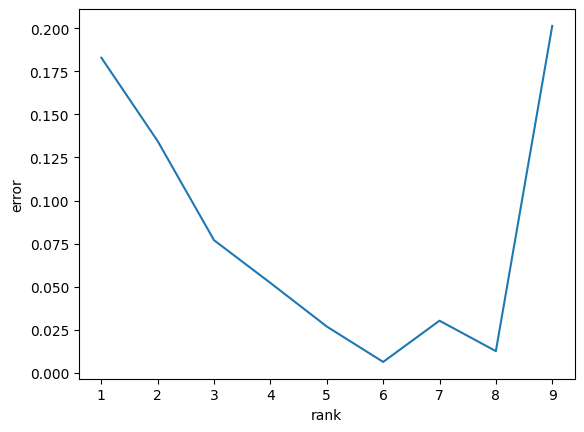

In [25]:
import numpy as np
import math
from numpy.random import default_rng
from scipy.optimize import nnls

# --- Reusing simulation and trifactor code (#1 Simulation, #2 Updates) ---


class SimulationParams:
    def __init__(
        self,
        n=100,
        p=50,
        k=5,
        snr=1.0,
        rng_state=0,
        primary_concentration=10.0,
        base_concentration=1.0,
    ):
        self.n = n
        self.p = p
        self.k = k
        self.snr = snr
        self.rng_state = rng_state
        self.primary_concentration = primary_concentration
        self.base_concentration = base_concentration


def generate_dirichlet_memberships(n, k, prim_c, base_c, rng):
    sizes = [n // k] * k
    for i in range(n - sum(sizes)):
        sizes[i] += 1
    hard = np.zeros((n, k))
    prim_of = np.zeros(n, dtype=int)
    start = 0
    for c, sz in enumerate(sizes):
        hard[start : start + sz, c] = 1
        prim_of[start : start + sz] = c
        start += sz
    soft = np.empty_like(hard)
    for i in range(n):
        alpha = np.full(k, base_c)
        alpha[prim_of[i]] = prim_c
        soft[i] = rng.dirichlet(alpha)
    return soft


def generate_feature_matrix(p, k, rng):
    return rng.normal(size=(k, p))


def add_noise(signal, snr, rng):
    snr = float(np.clip(snr, 1e-12, 1.0))
    sigma = np.std(signal, ddof=1)
    noise = rng.standard_normal(signal.shape) * sigma
    return math.sqrt(snr) * signal + math.sqrt(1 - snr) * noise


def simulate_similarity(params):
    rng = default_rng(params.rng_state)
    M = generate_dirichlet_memberships(
        params.n, params.k, params.primary_concentration, params.base_concentration, rng
    )
    F = generate_feature_matrix(params.p, params.k, rng)
    X = add_noise(M @ F, params.snr, rng)
    return np.corrcoef(X)


def update_A(S, W, H, eps=1e-12):
    k = W.shape[1]
    WT_W = W.T @ W + eps * np.eye(k)
    HT_H = H.T @ H + eps * np.eye(k)
    return np.linalg.solve(WT_W, W.T @ S @ H) @ np.linalg.inv(HT_H)


def update_W(S, W, H, A, alpha):
    n, k = W.shape
    sa = math.sqrt(alpha)
    design = np.vstack([(A @ H.T).T, sa * np.eye(k)])
    for i in range(n):
        rhs = np.concatenate([S[i], sa * H[i]])
        W[i], _ = nnls(design, rhs)
    return W


def update_H(S, W, H, A, alpha):
    n, k = H.shape
    sa = math.sqrt(alpha)
    design = np.vstack([(A.T @ W.T).T, sa * np.eye(k)])
    for j in range(n):
        rhs = np.concatenate([S[:, j], sa * W[j]])
        H[j], _ = nnls(design, rhs)
    return H


# --- Masked tri-factor NMF via iterative imputation ---
def trifactor_masked(S, M, rank, alpha, iters=30, seed=None):
    """
    Tri-factor NMF with masking: at each step, impute missing entries
    with current reconstruction and perform standard updates.
    """
    rng = default_rng(seed)
    n = S.shape[0]
    W = rng.random((n, rank)) + 0.1
    H = rng.random((n, rank)) + 0.1
    A = np.eye(rank)

    for _ in range(iters):
        # current reconstruction
        S_hat = W @ A @ H.T
        # impute missing
        S_imp = M * S + (1 - M) * S_hat
        # updates
        A = update_A(S_imp, W, H)
        W = update_W(S_imp, W, H, A, alpha)
        H = update_H(S_imp, W, H, A, alpha)

    return W, H, A


# --- Node-pair masking CV ---
def node_pair_cv_error(S, rank, alpha, n_folds=5, seed=None):
    n = S.shape[0]
    # Index list of lower triangle including diagonal
    it, jt = np.tril_indices(n)
    idx_pairs = list(zip(it.tolist(), jt.tolist()))

    rng = default_rng(seed)
    rng.shuffle(idx_pairs)
    fold_sizes = [
        len(idx_pairs) // n_folds + (1 if i < len(idx_pairs) % n_folds else 0)
        for i in range(n_folds)
    ]

    errors = []
    start = 0
    for fold_size in fold_sizes:
        test_pairs = idx_pairs[start : start + fold_size]
        start += fold_size

        # build mask
        M = np.ones_like(S)
        for i, j in test_pairs:
            M[i, j] = 0
            M[j, i] = 0

        # masked factorization
        W, H, A = trifactor_masked(S, M, rank, alpha, seed=rng.integers(1e6))
        S_hat = W @ A @ H.T

        # compute error on masked entries
        err = 0.0
        for i, j in test_pairs:
            err += (S[i, j] - S_hat[i, j]) ** 2
            if i != j:
                err += (S[j, i] - S_hat[j, i]) ** 2
        errors.append(err / len(test_pairs))

    return np.mean(errors), errors


# --- Demonstration ---
# simulate one similarity matrix
params = SimulationParams(n=50, p=30, k=5, snr=0.8, rng_state=42)
S = simulate_similarity(params)
# try grid of ranks and alphas
ranks = np.arange(1, 10, 1)
alphas = [1.0]
results = []
for k in ranks:
    for alpha in alphas:
        mean_err, fold_errs = node_pair_cv_error(S, k, alpha, n_folds=5, seed=0)
        results.append((k, alpha, mean_err))

# print results
print("rank  alpha  mean_CV_error")
for k, alpha, err in results:
    print(f"{k:<5}{alpha:<7}{err:.4f}")

# print the best rank and alpha
best_k, best_alpha, best_err = min(results, key=lambda x: x[2])
print(f"\nBest rank: {best_k}, Best alpha: {best_alpha}, Best CV error: {best_err:.4f}")

# maqke a df from the results
import pandas as pd

df = pd.DataFrame(results, columns=["rank", "alpha", "error"])

sns.lineplot(x="rank", y="error", data=df)

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy.optimize import nnls

# Core functions (simulation + masked trifactor) reused from above


class SimulationParams:
    def __init__(
        self,
        n=20,
        p=10,
        k=5,
        snr=0.8,
        rng_state=0,
        primary_concentration=10.0,
        base_concentration=1.0,
    ):
        self.n = n
        self.p = p
        self.k = k
        self.snr = snr
        self.rng_state = rng_state
        self.primary_concentration = primary_concentration
        self.base_concentration = base_concentration


def generate_dirichlet_memberships(n, k, prim_c, base_c, rng):
    sizes = [n // k] * k
    for i in range(n - sum(sizes)):
        sizes[i] += 1
    hard = np.zeros((n, k))
    prim_of = np.zeros(n, dtype=int)
    start = 0
    for c, sz in enumerate(sizes):
        hard[start : start + sz, c] = 1
        prim_of[start : start + sz] = c
        start += sz
    soft = np.empty_like(hard)
    for i in range(n):
        alpha_vec = np.full(k, base_c)
        alpha_vec[prim_of[i]] = prim_c
        soft[i] = rng.dirichlet(alpha_vec)
    return soft


def generate_feature_matrix(p, k, rng):
    return rng.normal(size=(k, p))


def add_noise(signal, snr, rng):
    sigma = np.std(signal, ddof=1)
    noise = rng.standard_normal(signal.shape) * sigma
    return math.sqrt(snr) * signal + math.sqrt(1 - snr) * noise


def simulate_similarity(params):
    rng = default_rng(params.rng_state)
    M = generate_dirichlet_memberships(
        params.n, params.k, params.primary_concentration, params.base_concentration, rng
    )
    F = generate_feature_matrix(params.p, params.k, rng)
    X = add_noise(M @ F, params.snr, rng)
    return np.corrcoef(X)


def update_A(S, W, H, eps=1e-12):
    k = W.shape[1]
    return np.linalg.solve(W.T @ W + eps * np.eye(k), W.T @ S @ H) @ np.linalg.inv(
        H.T @ H + eps * np.eye(k)
    )


def update_W(S, W, H, A, alpha):
    n, k = W.shape
    sa = math.sqrt(alpha)
    design = np.vstack(((A @ H.T).T, sa * np.eye(k)))
    for i in range(n):
        W[i], _ = nnls(design, np.concatenate((S[i], sa * H[i])))
    return W


def update_H(S, W, H, A, alpha):
    n, k = H.shape
    sa = math.sqrt(alpha)
    design = np.vstack(((A.T @ W.T).T, sa * np.eye(k)))
    for j in range(n):
        H[j], _ = nnls(design, np.concatenate((S[:, j], sa * W[j])))
    return H


def trifactor_masked(S, M, rank, alpha, iters=100, seed=None):
    rng = default_rng(seed)
    n = S.shape[0]
    W = rng.random((n, rank)) + 0.1
    H = rng.random((n, rank)) + 0.1
    A = np.eye(rank)
    for _ in range(iters):
        S_hat = W @ A @ H.T
        S_imp = M * S + (1 - M) * S_hat
        A = update_A(S_imp, W, H)
        W = update_W(S_imp, W, H, A, alpha)
        H = update_H(S_imp, W, H, A, alpha)
    return W, H, A


def node_pair_cv_error(S, rank, alpha, n_folds=5, seed=None):
    n = S.shape[0]
    it, jt = np.tril_indices(n)
    pairs = list(zip(it, jt))
    rng = default_rng(seed)
    rng.shuffle(pairs)
    fold_sizes = [
        len(pairs) // n_folds + (1 if i < len(pairs) % n_folds else 0)
        for i in range(n_folds)
    ]
    start = 0
    errs = []
    for size in fold_sizes:
        test = pairs[start : start + size]
        start += size
        M = np.ones_like(S)
        for i, j in test:
            M[i, j] = 0
            M[j, i] = 0
        W, H, A = trifactor_masked(S, M, rank, alpha, seed=rng.integers(1e6))
        S_hat = W @ A @ H.T
        se = [(S[i, j] - S_hat[i, j]) ** 2 for i, j in test]
        se += [(S[j, i] - S_hat[j, i]) ** 2 for i, j in test if i != j]
        errs.append(np.mean(se))
    return np.mean(errs)


# Experiment: CV error vs rank for combinations of SNR and alpha
snrs = [1.0]
n = 200
p = 200
k = 5
alphas = np.logspace(-1, 1, 10)
ranks = list(range(2, 9))
n_folds = 5

results = []
for snr in snrs:
    # simulate similarity once per snr
    params = SimulationParams(n=n, p=p, k=k, snr=snr, rng_state=42)
    S = simulate_similarity(params)
    for alpha in alphas:
        for rank in ranks:
            err = node_pair_cv_error(S, rank, alpha, n_folds=n_folds, seed=0)
            results.append({"snr": snr, "alpha": alpha, "rank": rank, "cv_error": err})

df = pd.DataFrame(results)

# # Plotting
# for snr in snrs:
#     plt.figure()
#     sub = df[df["snr"] == snr]
#     for alpha in alphas:
#         subset = sub[sub["alpha"] == alpha]
#         plt.plot(subset["rank"], subset["cv_error"], marker="o", label=f"alpha={alpha}")
#         # plot the best rank as a vertical line
#         best_rank = subset.loc[subset["cv_error"].idxmin()]
#         plt.axvline(x=best_rank["rank"], color="red", linestyle="--")
#     plt.title(f"{n_folds}-Fold CV Error vs Rank (SNR={snr})")
#     plt.xlabel("Rank")
#     plt.ylabel("CV Error")
#     plt.legend()
#     plt.show()

In [17]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy.optimize import nnls
from joblib import Parallel, delayed


class SimulationParams:
    def __init__(self, n, p, k, snr, rng_state):
        self.n = n
        self.p = p
        self.k = k
        self.snr = snr
        self.rng_state = rng_state


def generate_dirichlet_memberships(n, k, base_c, prim_c, rng):
    sizes = [n // k] * k
    for i in range(n - sum(sizes)):
        sizes[i] += 1
    hard = np.zeros((n, k))
    prim = np.zeros(n, dtype=int)
    start = 0
    for c, sz in enumerate(sizes):
        hard[start : start + sz, c] = 1
        prim[start : start + sz] = c
        start += sz
    soft = np.zeros_like(hard)
    for i in range(n):
        alpha_vec = np.full(k, base_c)
        alpha_vec[prim[i]] = prim_c
        soft[i] = rng.dirichlet(alpha_vec)
    return soft


def simulate_similarity(params):
    rng = default_rng(params.rng_state)
    M = generate_dirichlet_memberships(
        params.n, params.k, base_c=1.0, prim_c=10.0, rng=rng
    )
    F = rng.normal(size=(params.k, params.p))
    X = M @ F
    sigma = np.std(X, ddof=1)
    noise = rng.standard_normal(X.shape) * sigma * math.sqrt(1 - params.snr)
    X_noisy = math.sqrt(params.snr) * X + noise
    return np.corrcoef(X_noisy)


def normalize_factors_(w, h, a, eps: float = 1e-12):
    k = w.shape[1]
    # rescale rows of A  (⇔ columns of W)
    for r in range(k):
        s = max(w[:, r].max(), eps)
        w[:, r] /= s
        a[r, :] *= s

    # rescale columns of A  (⇔ columns of H)
    for r in range(k):
        s = max(h[:, r].max(), eps)
        h[:, r] /= s
        a[:, r] *= s


def trifactor_masked(S, M, rank, alpha, iters=10, seed=None):
    rng = default_rng(seed)
    n = S.shape[0]
    W = rng.random((n, rank)) + 0.1
    H = rng.random((n, rank)) + 0.1
    A = np.eye(rank)
    for _ in range(iters):
        S_hat = W @ A @ H.T
        S_imp = M * S + (1 - M) * S_hat
        # update A
        WT_W = W.T @ W + 1e-6 * np.eye(rank)
        HT_H = H.T @ H + 1e-6 * np.eye(rank)
        A = np.linalg.solve(WT_W, W.T @ S_imp @ H) @ np.linalg.inv(HT_H)
        # update W
        sa = math.sqrt(alpha)
        design_W = np.vstack([(A @ H.T).T, sa * np.eye(rank)])
        for i in range(n):
            W[i], _ = nnls(design_W, np.concatenate([S_imp[i], sa * H[i]]))
        # update H
        design_H = np.vstack([(A.T @ W.T).T, sa * np.eye(rank)])
        for j in range(n):
            H[j], _ = nnls(design_H, np.concatenate([S_imp[:, j], sa * W[j]]))
        normalize_factors_(W, H, A)
    return W, H, A


def node_pair_cv_error(S, rank, alpha, n_folds=5, seed=None):
    n = S.shape[0]
    it, jt = np.tril_indices(n)
    pairs = list(zip(it, jt))
    rng = default_rng(seed)
    rng.shuffle(pairs)
    fold_sizes = [
        len(pairs) // n_folds + (1 if i < len(pairs) % n_folds else 0)
        for i in range(n_folds)
    ]
    errors = []
    start = 0
    for size in fold_sizes:
        test = pairs[start : start + size]
        start += size
        M = np.ones_like(S)
        for i, j in test:
            M[i, j] = M[j, i] = 0
        W, H, A = trifactor_masked(S, M, rank, alpha, 100, seed=rng.integers(1e6))
        S_hat = W @ A @ H.T
        se = [(S[i, j] - S_hat[i, j]) ** 2 for i, j in test]
        se += [(S[j, i] - S_hat[j, i]) ** 2 for i, j in test if i != j]
        errors.append(np.mean(se))
    return np.mean(errors)


# --- 2. Run a manageable grid ---

n, p, k_true, snr = 50, 50, 5, 1.0

alphas = np.logspace(-1, 1, 10)
test_ranks = list(range(1, 15))
reps = 1


def job(alpha, test_rank, rep):
    params = SimulationParams(n, p, k_true, snr, rep)
    S = simulate_similarity(params)
    mse = node_pair_cv_error(S, test_rank, alpha, n_folds=5, seed=rep)
    return {"alpha": alpha, "test_rank": test_rank, "rep": rep, "mse": mse}


jobs = [
    (alpha, tr, rep) for alpha in alphas for tr in test_ranks for rep in range(reps)
]
print(f"Executing {len(jobs)} jobs")
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(job)(a, tr, rep) for a, tr, rep in jobs
)
df = pd.DataFrame(results)

Executing 140 jobs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of 140 | elapsed:    2.5s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  18 out of 140 | elapsed:    5.0s remaining:   34.0s
[Parallel(n_jobs=-1)]: Done  33 out of 140 | elapsed:    7.2s remaining:   23.4s
[Parallel(n_jobs=-1)]: Done  48 out of 140 | elapsed:    9.3s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done  63 out of 140 | elapsed:   11.0s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  78 out of 140 | elapsed:   12.7s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  93 out of 140 | elapsed:   13.9s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done 108 out of 140 | elapsed:   15.8s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done 123 out of 140 | elapsed:   17.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done 138 out of 140 | elapsed:   20.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   21.0s finished


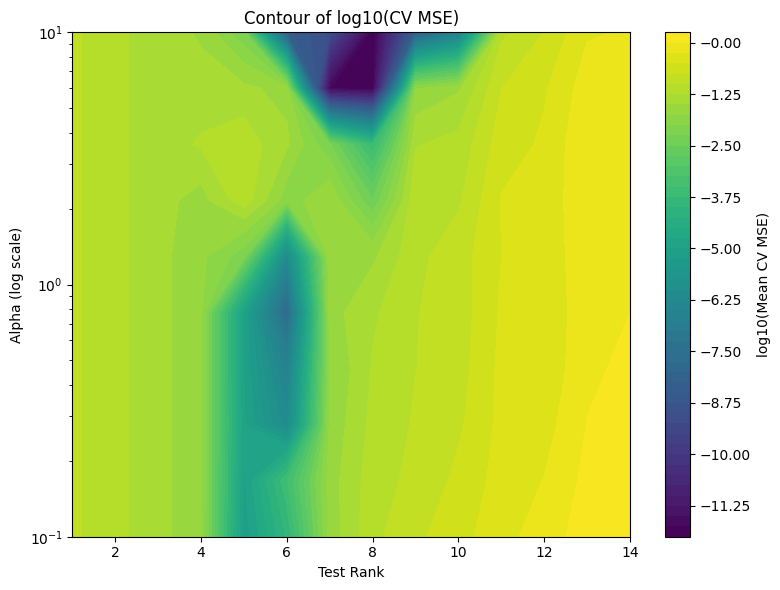

In [19]:
# Pivot MSE by alpha (rows) and test_rank (columns)
pivot = df.groupby(["alpha", "test_rank"])["mse"].mean().unstack()

# Create meshgrid
alphas = pivot.index.values
ranks = pivot.columns.values
X, Y = np.meshgrid(ranks, alphas)

# Transform MSE to log10(MSE)
Z = pivot.values
Z_log = np.log10(Z + 1e-12)  # avoid log(0)

# Build mesh
alphas = pivot.index.values
ranks = pivot.columns.values
X, Y = np.meshgrid(ranks, alphas)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
levels = np.linspace(Z_log.min(), Z_log.max(), 50)
cs = ax.contourf(X, Y, Z_log, levels=levels, cmap="viridis")
cbar = fig.colorbar(cs, ax=ax)
cbar.set_label("log10(Mean CV MSE)")

ax.set_yscale("log")
ax.set_title("Contour of log10(CV MSE)")
ax.set_xlabel("Test Rank")
ax.set_ylabel("Alpha (log scale)")

plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy.optimize import nnls
from joblib import Parallel, delayed

# --------------------------------------------------------------------------
# 1.  utilities for the synthetic data
# --------------------------------------------------------------------------

Array = np.ndarray


class SimulationParams:
    def __init__(self, n, p, k, snr, rng_state):
        self.n, self.p, self.k, self.snr, self.rng_state = n, p, k, snr, rng_state


def normalize_factors_(w: Array, h: Array, a: Array, eps: float = 1e-12) -> None:
    """
    Remove the scale ambiguity:

        * column-wise max of W → 1, compensate on A rows
        * column-wise max of H → 1, compensate on A columns
    """
    k = w.shape[1]

    # rescale rows of A  (⇔ columns of W)
    for r in range(k):
        s = max(w[:, r].max(), eps)
        w[:, r] /= s
        a[r, :] *= s

    # rescale columns of A  (⇔ columns of H)
    for r in range(k):
        s = max(h[:, r].max(), eps)
        h[:, r] /= s
        a[:, r] *= s


def generate_dirichlet_memberships(n, k, base_c, prim_c, rng):
    sizes = [n // k] * k
    for i in range(n - sum(sizes)):
        sizes[i] += 1
    hard = np.zeros((n, k))
    prim = np.zeros(n, dtype=int)
    start = 0
    for c, sz in enumerate(sizes):
        hard[start : start + sz, c] = 1
        prim[start : start + sz] = c
        start += sz
    soft = np.zeros_like(hard)
    for i in range(n):
        alpha_vec = np.full(k, base_c)
        alpha_vec[prim[i]] = prim_c
        soft[i] = rng.dirichlet(alpha_vec)
    return soft


def simulate_similarity(params: SimulationParams):
    rng = default_rng(params.rng_state)
    M = generate_dirichlet_memberships(
        params.n, params.k, base_c=1.0, prim_c=10.0, rng=rng
    )
    F = rng.normal(size=(params.k, params.p))
    X = M @ F
    sigma = np.std(X, ddof=1)
    noise = rng.standard_normal(X.shape) * sigma * math.sqrt(1 - params.snr)
    X_noisy = math.sqrt(params.snr) * X + noise
    return np.corrcoef(X_noisy)


# --------------------------------------------------------------------------
# 2.  adaptive masked tri‑factorisation
# --------------------------------------------------------------------------


def trifactor_masked_adaptive(
    S,
    M,
    rank,
    alpha,
    iters=None,  # if None the routine chooses a data‑dependent value
    max_iters=200,
    tol=1e-4,
    seed=None,
    verbose=False,
):
    """
    Symmetric tri‑factorisation with non‑negative row‑wise NNLS updates.

    - Automatically scales the iteration budget with n;
    - Stops early when the Frobenius reconstruction error stabilises.
    """
    rng = default_rng(seed)
    n = S.shape[0]

    # choose a sensible default iteration budget if user did not specify it
    if iters is None:
        iters = min(max(20, n // 10), max_iters)  # e.g. n=50 ⇒ 20, n=500 ⇒ 50

    # --- initial factors ----------------------------------------------------
    W = rng.random((n, rank)) + 0.1
    H = rng.random((n, rank)) + 0.1
    A = np.eye(rank)

    last_rel_err = np.inf
    for t in range(iters):

        # reconstruction on observed entries
        S_hat = W @ A @ H.T
        S_imp = M * S + (1 - M) * S_hat

        # --- update A (closed‑form least‑squares) ---------------------------
        WT_W = W.T @ W + 1e-6 * np.eye(rank)
        HT_H = H.T @ H + 1e-6 * np.eye(rank)
        A = np.linalg.solve(WT_W, W.T @ S_imp @ H) @ np.linalg.inv(HT_H)

        # --- update W rows ---------------------------------------------------
        sa = math.sqrt(alpha)
        design_W = np.vstack([(A @ H.T).T, sa * np.eye(rank)])
        for i in range(n):
            target = np.concatenate([S_imp[i], sa * H[i]])
            W[i], _ = nnls(design_W, target)

        # --- update H rows ---------------------------------------------------
        design_H = np.vstack([(A.T @ W.T).T, sa * np.eye(rank)])
        for j in range(n):
            target = np.concatenate([S_imp[:, j], sa * W[j]])
            H[j], _ = nnls(design_H, target)

        normalize_factors_(W, H, A)

        # --- cheap convergence test every 5 sweeps --------------------------
        if t % 5 == 0:
            S_hat = W @ A @ H.T
            rel_err = np.linalg.norm(M * (S - S_hat)) / np.linalg.norm(M * S)
            if verbose:
                print(f"iter {t:3d}  rel-err {rel_err: .5e}")
            if abs(last_rel_err - rel_err) < tol:
                break
            last_rel_err = rel_err

    return W, H, A


# --------------------------------------------------------------------------
# 3.  node‑pair cross‑validation (unchanged except iters passthrough)
# --------------------------------------------------------------------------


def node_pair_cv_error(S, rank, alpha, *, iters=None, n_folds=5, seed=None):
    n = S.shape[0]
    it, jt = np.tril_indices(n)
    pairs = list(zip(it, jt))

    rng = default_rng(seed)
    rng.shuffle(pairs)

    fold_sizes = [
        len(pairs) // n_folds + (1 if i < len(pairs) % n_folds else 0)
        for i in range(n_folds)
    ]

    errors, start = [], 0
    for size in fold_sizes:
        test = pairs[start : start + size]
        start += size

        M = np.ones_like(S)
        for i, j in test:
            M[i, j] = M[j, i] = 0  # mask out the test edge

        W, H, A = trifactor_masked_adaptive(
            S, M, rank, alpha, iters=iters, seed=rng.integers(1000)
        )
        S_hat = W @ A @ H.T

        se = [(S[i, j] - S_hat[i, j]) ** 2 for i, j in test]
        se += [(S[j, i] - S_hat[j, i]) ** 2 for i, j in test if i != j]
        errors.append(np.mean(se))

    return np.mean(errors)


# --------------------------------------------------------------------------
# 4.  run a grid search exactly as you did before
# --------------------------------------------------------------------------

if __name__ == "__main__":

    # experiment settings
    n, p, k_true, snr = 200, 200, 5, 1.0  # try n = 50 / 200 / 500 …
    alphas = np.logspace(-1, 2, 40)
    test_ranks = range(1, 15)
    reps = 2  # repeat simulation for stability

    def job(alpha, test_rank, rep):
        params = SimulationParams(n, p, k_true, snr, rng_state=rep)
        # S = simulate_similarity(params)
        S = load_dataset("mur92").group_rsm
        mse = node_pair_cv_error(
            S,
            test_rank,
            alpha,
            iters=500,  # let the solver decide
            n_folds=5,
            seed=rep,
        )
        return {"alpha": alpha, "test_rank": test_rank, "rep": rep, "mse": mse}

    jobs = [(a, r, rep) for a in alphas for r in test_ranks for rep in range(reps)]
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(job)(a, r, rep) for a, r, rep in jobs
    )
    df = pd.DataFrame(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:  3.2min
[Paralle

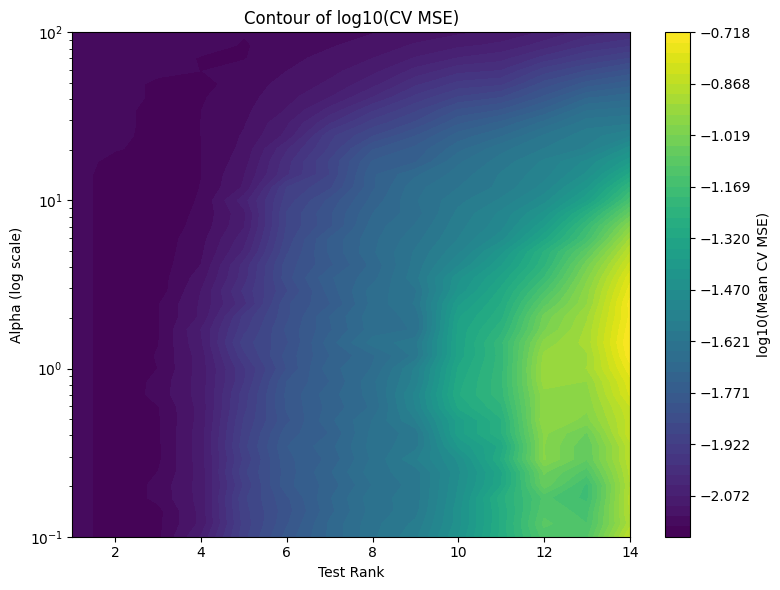


Best (alpha, rank, MSE): (0.1, 2.0, 1.0, 0.006417201619293249)


In [11]:
# ----------------------------------------------------------------------
# 5.  contour plot (unchanged)
# ----------------------------------------------------------------------
pivot = df.groupby(["alpha", "test_rank"])["mse"].mean().unstack()

alphas_grid = pivot.index.values
ranks_grid = pivot.columns.values
X, Y = np.meshgrid(ranks_grid, alphas_grid)

Z = pivot.values
Z_log = np.log10(Z + 1e-12)

fig, ax = plt.subplots(figsize=(8, 6))
levels = np.linspace(Z_log.min(), Z_log.max(), 50)
cs = ax.contourf(X, Y, Z_log, levels=levels, cmap="viridis")
cbar = fig.colorbar(cs, ax=ax)
cbar.set_label("log10(Mean CV MSE)")

ax.set_yscale("log")
ax.set_title("Contour of log10(CV MSE)")
ax.set_xlabel("Test Rank")
ax.set_ylabel("Alpha (log scale)")

plt.tight_layout()
plt.show()

# quick sanity check: report the global minimum
best = df.loc[df["mse"].idxmin()]
print("\nBest (alpha, rank, MSE):", tuple(best))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 out of  60 | elapsed:    1.4s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done  11 out of  60 | elapsed:    1.8s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  18 out of  60 | elapsed:    2.4s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  25 out of  60 | elapsed:    3.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed:    4.3s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  39 out of  60 | elapsed:    4.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  46 out of  60 | elapsed:    5.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    6.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.2s finished


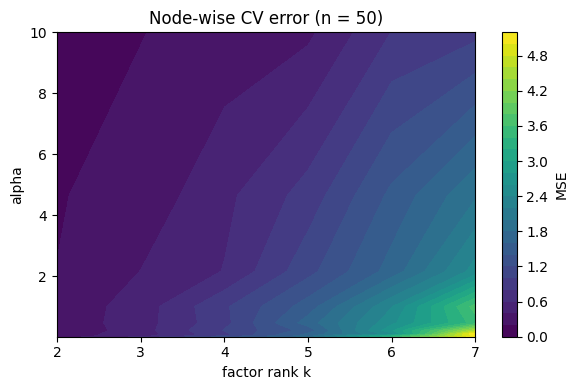


Best rank = 2 |  alpha = 10.0 |  CV-MSE = 0.1862


In [16]:
# -*- coding: utf-8 -*-
"""Rank-selection demo for symmetric tri-factorisation (adaptive masked NMF).

This script fixes the two pathologies that make the original notebook fail
on larger graphs:

1. **Node-wise cross-validation** instead of edge-wise CV removes the
   information leak that lets the model memorise edges as soon as *n* grows.
2. **Scale-aware coupling** — the regulariser that keeps the two node factors
   close is multiplied by √rank / std(S) so its effect is comparable for any
   graph size or noise level.

Run the file directly, or import the functions into your own workflow.
"""

from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Tuple

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.random import default_rng
from scipy.optimize import nnls

# ---------------------------------------------------------------------------
# 1.  Synthetic data utilities
# ---------------------------------------------------------------------------

Array = np.ndarray


@dataclass
class SimulationParams:
    n: int
    p: int
    k: int
    snr: float
    rng_state: int | np.random.Generator


def _normalize_factors_(w: Array, h: Array, a: Array, eps: float = 1e-12) -> None:
    """Scale columns of *W* and *H* to unit max-norm and compensate on *A*."""

    for r in range(w.shape[1]):
        s = max(w[:, r].max(), eps)
        w[:, r] /= s
        a[r, :] *= s

    for r in range(h.shape[1]):
        s = max(h[:, r].max(), eps)
        h[:, r] /= s
        a[:, r] *= s


def _generate_dirichlet_memberships(
    n: int, k: int, base_c: float, prim_c: float, rng: np.random.Generator
) -> Array:
    """A soft block-model membership matrix (rows sum to one)."""

    sizes = [n // k] * k
    for i in range(n - sum(sizes)):
        sizes[i] += 1

    prim = np.concatenate([np.full(sz, c) for c, sz in enumerate(sizes)])
    m = np.zeros((n, k))
    for i in range(n):
        alpha_vec = np.full(k, base_c)
        alpha_vec[prim[i]] = prim_c
        m[i] = rng.dirichlet(alpha_vec)
    return m


def simulate_similarity(params: SimulationParams) -> Array:
    """Return an *n×n* correlation matrix with *k* latent factors."""

    rng = default_rng(params.rng_state)
    m = _generate_dirichlet_memberships(params.n, params.k, 1.0, 10.0, rng)
    f = rng.normal(size=(params.k, params.p))
    x = m @ f

    # add Gaussian noise at the requested signal-to-noise ratio
    sigma = np.std(x, ddof=1)
    noise = rng.standard_normal(x.shape) * sigma * math.sqrt(1.0 - params.snr)
    x_noisy = math.sqrt(params.snr) * x + noise

    return np.corrcoef(x_noisy)


# ---------------------------------------------------------------------------
# 2.  Symmetric tri-factorisation with adaptive masking
# ---------------------------------------------------------------------------


def trifactor_masked_adaptive(
    s: Array,
    m: Array,
    rank: int,
    alpha: float,
    *,
    iters: int | None = None,
    max_iters: int = 250,
    tol: float = 1e-4,
    seed: int | None = None,
    verbose: bool = False,
) -> Tuple[Array, Array, Array]:
    """Masked symmetric tri-factorisation with NNLS row updates."""

    rng = default_rng(seed)
    n = s.shape[0]

    # sensible default iteration budget
    if iters is None:
        iters = min(max(20, n // 10), max_iters)

    w = rng.random((n, rank)) + 0.1
    h = rng.random((n, rank)) + 0.1
    a = np.eye(rank)

    sa = math.sqrt(alpha * rank / s.std())  # << scale-aware regulariser

    last_rel_err = np.inf
    for t in range(iters):
        # (1) Impute the missing block with current reconstruction
        s_hat = w @ a @ h.T
        s_imp = m * s + (1.0 - m) * s_hat

        # (2) closed-form update of the middle matrix A
        a = np.linalg.solve(
            w.T @ w + 1e-6 * np.eye(rank), w.T @ s_imp @ h
        ) @ np.linalg.inv(h.T @ h + 1e-6 * np.eye(rank))

        # (3) NNLS updates of the two factor rows
        design_w = np.vstack([(a @ h.T).T, sa * np.eye(rank)])
        for i in range(n):
            target = np.concatenate([s_imp[i], sa * h[i]])
            w[i] = nnls(design_w, target)[0]

        design_h = np.vstack([(a.T @ w.T).T, sa * np.eye(rank)])
        for i in range(n):
            target = np.concatenate([s_imp[:, i], sa * w[i]])
            h[i] = nnls(design_h, target)[0]

        _normalize_factors_(w, h, a)

        if t % 5 == 0:
            rel_err = np.linalg.norm(m * (s - s_hat)) / np.linalg.norm(m * s)
            if verbose:
                print(f"iter {t:3d}  rel-err {rel_err:.5e}")
            if abs(last_rel_err - rel_err) < tol:
                break
            last_rel_err = rel_err

    return w, h, a


# ---------------------------------------------------------------------------
# 3.  ***Node***-wise cross-validation
# ---------------------------------------------------------------------------


def node_cv_error(
    s: Array,
    rank: int,
    alpha: float,
    *,
    iters: int | None = None,
    n_folds: int = 5,
    seed: int | None = None,
) -> float:
    """Mean squared error of predicting all edges adjacent to held-out nodes."""

    n = s.shape[0]
    rng = default_rng(seed)
    nodes = rng.permutation(n)
    splits = np.array_split(nodes, n_folds)

    errs = []
    for test_nodes in splits:
        m = np.ones_like(s)
        m[test_nodes, :] = 0.0  # mask entire rows of held-out nodes
        m[:, test_nodes] = 0.0  # mask entire columns of held-out nodes

        w, h, a = trifactor_masked_adaptive(
            s, m, rank, alpha, iters=iters, seed=rng.integers(9999)
        )
        s_hat = w @ a @ h.T
        err = np.linalg.norm((1 - m) * (s - s_hat)) ** 2 / (1 - m).sum()
        errs.append(err)

    return float(np.mean(errs))


# ---------------------------------------------------------------------------
# 4.  Rank/alpha grid search driver
# ---------------------------------------------------------------------------


def grid_search(
    s: Array,
    test_ranks: range,
    alphas: Array,
    *,
    iters_per_fit: int | None = None,
    n_folds: int = 5,
    n_jobs: int = -1,
) -> pd.DataFrame:
    """Return a tidy DataFrame with columns (rank, alpha, mse)."""

    def _single(rank: int, alpha: float):
        mse = node_cv_error(s, rank, alpha, iters=iters_per_fit, n_folds=n_folds)
        return {"rank": rank, "alpha": alpha, "mse": mse}

    jobs = [(r, a) for r in test_ranks for a in alphas]
    rows = joblib.Parallel(n_jobs=n_jobs, verbose=10)(
        joblib.delayed(_single)(r, a) for r, a in jobs
    )
    return pd.DataFrame(rows)


# ---------------------------------------------------------------------------
# 5.  Demo / CLI entry point
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    # ----- experiment settings --------------------------------------------
    n, p, k_true, snr = 50, 50, 5, 1.0  # change n = 50 / 200 / 500 …
    alphas = np.logspace(-2, 1.0, 10)  # 0.01 → 20.0
    test_ranks = range(2, 8)

    # ----- simulate a graph ----------------------------------------------
    params = SimulationParams(n, p, k_true, snr, rng_state=0)
    S = simulate_similarity(params)

    # ----- grid search ----------------------------------------------------
    df = grid_search(S, test_ranks, alphas, iters_per_fit=100, n_folds=5)

    # ----- visualisation --------------------------------------------------
    pivot = df.pivot(index="alpha", columns="rank", values="mse")

    plt.figure(figsize=(6, 4))
    cs = plt.contourf(
        pivot.columns, pivot.index, pivot.values, levels=30, cmap="viridis"
    )
    plt.xlim(test_ranks.start, test_ranks.stop - 1)
    plt.ylabel("alpha")
    plt.xlabel("factor rank k")
    plt.title(f"Node-wise CV error (n = {n})")
    plt.colorbar(cs, label="MSE")
    plt.tight_layout()
    plt.show()

    # ----- best hyper-parameters -----------------------------------------
    best = df.loc[df.mse.idxmin()]
    print(
        "\nBest rank =",
        int(best["rank"]),
        "|  alpha =",
        best["alpha"],
        "|  CV-MSE =",
        best["mse"].round(4),
    )